In [1]:
# Paso 0: Importar librerias necesarias

import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import pylab as plt
from pandas.plotting import lag_plot


In [2]:
# Paso 1: Importar el DF de todas las empresas del IBEX 35

df = pd.read_csv('ibex35.csv')

df.head()

,id,ticker,empresa,date,open,high,low,close,adj close,volume
0,1,ANA,Acciona,2019-01-02,73.900002,73.900002,73.900002,73.900002,64.148270,0
1,1,ANA,Acciona,2022-06-24,174.199997,178.800003,174.000000,178.800003,169.562302,0
2,1,ANA,Acciona,2022-06-23,169.899994,173.199997,169.000000,173.000000,164.061951,0
3,1,ANA,Acciona,2022-06-22,171.399994,171.399994,168.800003,170.199997,161.406616,0
4,1,ANA,Acciona,2022-06-21,179.699997,179.699997,172.300003,173.600006,164.630966,0


In [3]:
# Paso 2: Filtrar por la empresa sobre la que realizar el modelo

mapfre = df[df['empresa'] == 'mapfre']

mapfre.shape

(1325, 10)

In [4]:
# Paso 3: Seleccionar las columnas definitivas que utilizaremos

mapfre = mapfre [['date','open','high','low','close','adj close']]

mapfre.shape

(1325, 6)

In [5]:
# Paso 4: Modificar el formato de columna 'date' (format: object ===> datatime)

mapfre['date'] = pd.to_datetime(mapfre['date'], format="%Y-%m-%d")

mapfre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1325 entries, 29825 to 31149
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1325 non-null   datetime64[ns]
 1   open       1325 non-null   float64       
 2   high       1325 non-null   float64       
 3   low        1325 non-null   float64       
 4   close      1325 non-null   float64       
 5   adj close  1325 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 72.5 KB


In [6]:
# Paso 5: Ordenar el DF por fecha

mapfre.sort_values(by='date',ascending= True, inplace=True)

mapfre.head()

,date,open,high,low,close,adj close
31025,2019-01-02,2.310,2.319,2.252,2.295,1.515935
31024,2019-01-03,2.292,2.318,2.281,2.306,1.523200
31023,2019-01-04,2.320,2.373,2.312,2.371,1.566135
31022,2019-01-07,2.380,2.398,2.364,2.370,1.565475
31021,2019-01-08,2.358,2.373,2.333,2.367,1.563493


In [7]:
# Paso 6: Filtrar nuevamente para eliminar efecto COVID del análisis (previo a 2021)

# Filtro:

fecha_inicio = '2021-01-01'
fecha_fin = '2024-03-01'

mapfre = mapfre[(mapfre['date'] >= fecha_inicio) & (mapfre['date'] <= fecha_fin)]

# Comprobar si se ha aplicado correctamente

mapfre.shape

(812, 6)

In [8]:
# Paso 7: Añadir al DF fechas obviadas por mercado de valores español (fin de semana y festivos)

# Rango de fechas desde '2021-01-01' a '2024-03-01'

date_range = pd.date_range(start=mapfre['date'].min(), end=mapfre['date'].max(), freq='D')

# Reindexa el DF con el nuevo rango de fechas

mapfre = mapfre.set_index('date').reindex(date_range).reset_index()

# Volver a modificar el nombre de columna 'date'

mapfre = mapfre.rename(columns={'index': 'date'})


In [9]:
# Paso 8: Comprobar que ha introducido la fechas ausentes en el DF original

mapfre.head(10)

,date,open,high,low,close,adj close
0,2021-01-04,1.607,1.624,1.573,1.585,1.200315
1,2021-01-05,1.580,1.612,1.575,1.599,1.210918
2,2021-01-06,1.615,1.654,1.606,1.643,1.244239
3,2021-01-07,1.653,1.653,1.626,1.647,1.247268
4,2021-01-08,1.658,1.663,1.637,1.644,1.244996
5,2021-01-09,NaN,NaN,NaN,NaN,NaN
6,2021-01-10,NaN,NaN,NaN,NaN,NaN
7,2021-01-11,1.639,1.644,1.619,1.631,1.235151
8,2021-01-12,1.645,1.658,1.635,1.641,1.242724
9,2021-01-13,1.639,1.645,1.618,1.634,1.237423


In [10]:
# Paso 9: Rellenar valores nulos con el anterior valor de la columna(viernes o previo a festivo)

mapfre = mapfre.fillna(method='ffill')

In [11]:
# Paso 10: Comprobar que se han introducido los valores correctamente


mapfre.head(10)

,date,open,high,low,close,adj close
0,2021-01-04,1.607,1.624,1.573,1.585,1.200315
1,2021-01-05,1.580,1.612,1.575,1.599,1.210918
2,2021-01-06,1.615,1.654,1.606,1.643,1.244239
3,2021-01-07,1.653,1.653,1.626,1.647,1.247268
4,2021-01-08,1.658,1.663,1.637,1.644,1.244996
5,2021-01-09,1.658,1.663,1.637,1.644,1.244996
6,2021-01-10,1.658,1.663,1.637,1.644,1.244996
7,2021-01-11,1.639,1.644,1.619,1.631,1.235151
8,2021-01-12,1.645,1.658,1.635,1.641,1.242724
9,2021-01-13,1.639,1.645,1.618,1.634,1.237423


In [12]:
# Paso 11: Establecer columna 'date' como índice para modelo

mapfre = mapfre.set_index('date')

mapfre.head(10)

,open,high,low,close,adj close
date,,,,,
2021-01-04,1.607,1.624,1.573,1.585,1.200315
2021-01-05,1.580,1.612,1.575,1.599,1.210918
2021-01-06,1.615,1.654,1.606,1.643,1.244239
2021-01-07,1.653,1.653,1.626,1.647,1.247268
2021-01-08,1.658,1.663,1.637,1.644,1.244996
2021-01-09,1.658,1.663,1.637,1.644,1.244996
2021-01-10,1.658,1.663,1.637,1.644,1.244996
2021-01-11,1.639,1.644,1.619,1.631,1.235151
2021-01-12,1.645,1.658,1.635,1.641,1.242724


In [13]:
# Paso 12: Establecer siguiente criterio para que el modelo AR funcione

mapfre.index = pd.DatetimeIndex(mapfre.index).to_period('d')

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

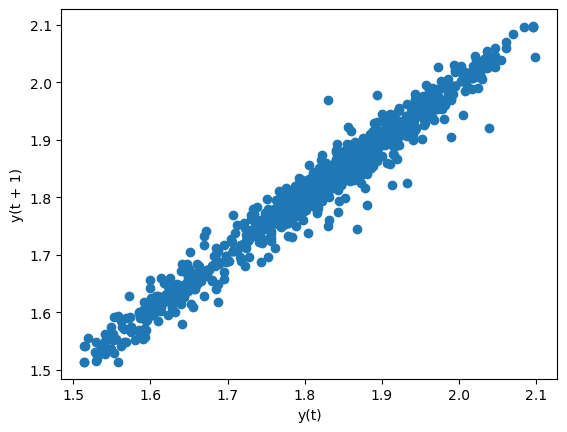

In [14]:
# Paso 13: Comprobar linealidad de la variable y = 'close'

lag_plot(mapfre.close)

In [15]:
# Paso 14: Importar modelo de AR

from statsmodels.tsa.ar_model import AutoReg as AR

In [16]:
# Paso 15: Realizar el split en el DF del train y el test

train, test = mapfre.close[:-10], mapfre.close[-10:]

train.shape, test.shape

((1143,), (10,))

In [17]:
# Paso 16: Entrenar el modelo de AR

modelo = AR(train, lags=1).fit()

In [18]:
# Paso 17: Realizar predicción con el entrenamiento

pred = modelo.predict(len(train), len(mapfre.close)-1)

# Check sobre los valores de la predicción

pred

2024-02-21    1.948427
2024-02-22    1.946877
2024-02-23    1.945349
2024-02-24    1.943844
2024-02-25    1.942361
2024-02-26    1.940900
2024-02-27    1.939459
2024-02-28    1.938040
2024-02-29    1.936642
2024-03-01    1.935264
Freq: D, dtype: float64

In [19]:
# Paso 18: Chequear coincidencia entre test y pred

test

date
2024-02-21    1.962
2024-02-22    1.977
2024-02-23    1.969
2024-02-24    1.969
2024-02-25    1.969
2024-02-26    1.970
2024-02-27    1.965
2024-02-28    1.962
2024-02-29    1.959
2024-03-01    1.974
Freq: D, Name: close, dtype: float64

In [20]:
# Paso 19: Calcular el error de la predicción sobre la realidad

error = (pred - test).abs().sum()/len(pred)  

error

0.02588366015047283

In [21]:
# Paso 20: Generar un DF sobre la comparativa en realidad, predicción y error

res=pd.DataFrame({'real': test, 'pred': pred, 'error': pred - test})

res

,real,pred,error
2024-02-21,1.962,1.948427,-0.013573
2024-02-22,1.977,1.946877,-0.030123
2024-02-23,1.969,1.945349,-0.023651
2024-02-24,1.969,1.943844,-0.025156
2024-02-25,1.969,1.942361,-0.026639
2024-02-26,1.970,1.940900,-0.029100
2024-02-27,1.965,1.939459,-0.025541
2024-02-28,1.962,1.938040,-0.023960
2024-02-29,1.959,1.936642,-0.022358
2024-03-01,1.974,1.935264,-0.038736
